In [1]:
# import all shit that we need
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.metrics import accuracy_score, classification_report
import optuna
import xgboost as xgb

In [2]:
# load wiuwiuwiwuwiu
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [3]:
train_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...,...
18519,18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert
18522,18522,NaN,Yes,1.0,0.0,Yes,5.0,2.0,Introvert


In [4]:
# FILL ALL NaN's with mode. Why do it? idk, i just feel that we need to do it) &_& 
# NaN is BAD!

train_df.dropna(axis=0, subset=['Time_spent_Alone'], inplace=True)

train_df.dropna(axis=0, thresh=7, inplace=True)

mode_value = train_df['Social_event_attendance'].mode()[0]
train_df.fillna({'Social_event_attendance' : mode_value}, inplace=True)
test_df.fillna({'Social_event_attendance' : mode_value}, inplace=True)


mode_value = train_df['Going_outside'].mode()[0]
train_df.fillna({'Going_outside' : mode_value}, inplace=True)
test_df.fillna({'Going_outside' : mode_value}, inplace=True)


mode_value = train_df['Drained_after_socializing'].mode()[0]
train_df.fillna({'Drained_after_socializing' : mode_value}, inplace=True)
test_df.fillna({'Drained_after_socializing' : mode_value}, inplace=True)


mode_value = train_df['Friends_circle_size'].mode()[0]
train_df.fillna({'Friends_circle_size' : mode_value}, inplace=True)
test_df.fillna({'Friends_circle_size' : mode_value}, inplace=True)


mode_value = train_df['Post_frequency'].mode()[0]
train_df.fillna({'Post_frequency' : mode_value}, inplace=True)
test_df.fillna({'Post_frequency' : mode_value}, inplace=True)

In [5]:
# Undersampling madafaka
n = 400
zero_rows = train_df[train_df['Time_spent_Alone'] == 0]
drop_indices = zero_rows.sample(n=n, random_state=42).index
train_df.drop(index=drop_indices, inplace=True)

train_df['Time_spent_Alone'], _ = boxcox(train_df['Time_spent_Alone'] + 1)

p-value: 1.5103819206779706e-62


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16909.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


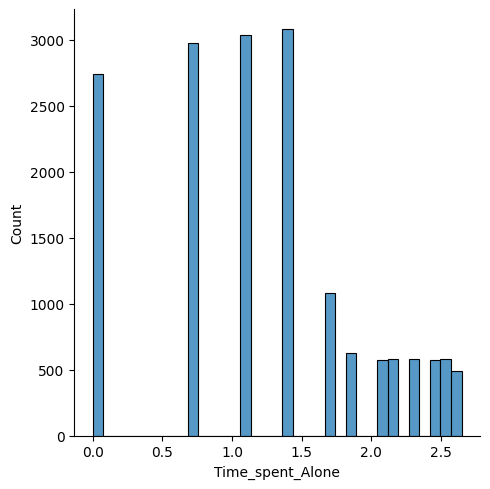

In [6]:
# UUUUUU look at this distribution in column
stat, p = shapiro(train_df['Time_spent_Alone'])
print(f"p-value: {p}")
sns.displot(train_df['Time_spent_Alone'])

In [7]:
# Simple Encoding for our categ. columns
train_df[['Stage_fear', 'Drained_after_socializing']] = (
    train_df[['Stage_fear', 'Drained_after_socializing']]
    .replace({'Yes': 1, 'No': 0})
    .infer_objects(copy=False)
)

train_df['Personality'] = (
    train_df['Personality']
    .replace({'Introvert': 0, 'Extrovert': 1})
    .infer_objects(copy=False)
)

test_df[['Stage_fear', 'Drained_after_socializing']] = (
    test_df[['Stage_fear', 'Drained_after_socializing']]
    .replace({'Yes': 1, 'No': 0})
    .infer_objects(copy=False)
)

/tmp/ipykernel_13/1660619562.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_13/1660619562.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'Introvert': 0, 'Extrovert': 1})
/tmp/ipykernel_13/1660619562.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

In [8]:
# Makeing some stupid-way(tak nado blya) undersampling
n = 50
zero_rows = train_df[train_df['Stage_fear'] == 0]
drop_indices = zero_rows.sample(n=n, random_state=42).index
train_df.drop(index=drop_indices, inplace=True)

zero_rows = train_df[train_df['Stage_fear'] == 0]
drop_indices = zero_rows.sample(n=n, random_state=42).index
train_df.drop(index=drop_indices, inplace=True)

zero_rows = train_df[train_df['Stage_fear'] == 0]
drop_indices = zero_rows.sample(n=n, random_state=42).index
train_df.drop(index=drop_indices, inplace=True)

zero_rows = train_df[train_df['Stage_fear'] == 0]
drop_indices = zero_rows.sample(n=n, random_state=42).index
train_df.drop(index=drop_indices, inplace=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


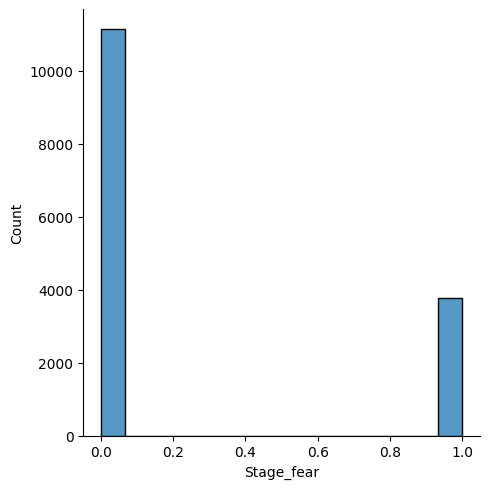

In [9]:
# UUUUUU look at this distribution in column
sns.displot(train_df['Stage_fear'])

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16709.
  res = hypotest_fun_out(*samples, **kwds)


p-value: 2.7750473881880377e-55


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


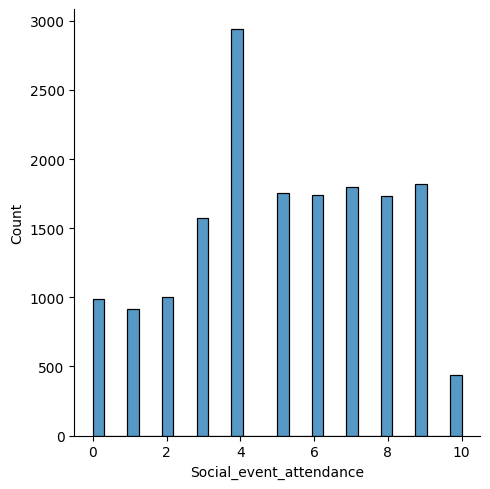

In [10]:
# UUUUUU look at this distribution in column
stat, p = shapiro(train_df['Social_event_attendance'])
print(f"p-value: {p}")
sns.displot(train_df['Social_event_attendance'])

In [11]:
# Undersampling madafaka
n = 100
zero_rows = train_df[train_df['Social_event_attendance'] == 4]
drop_indices = zero_rows.sample(n=n, random_state=42).index
train_df.drop(index=drop_indices, inplace=True)

zero_rows = train_df[train_df['Social_event_attendance'] == 4]
drop_indices = zero_rows.sample(n=n, random_state=42).index
train_df.drop(index=drop_indices, inplace=True)

In [12]:
test_ids = test_df['id']
test_data = test_df.drop(['id'], axis=1)

In [13]:
# BTW xgb with optuned parameters
y = train_df['Personality']
X = train_df.drop(['Personality', 'id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1300,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.7215006154516073,
    colsample_bytree=0.9273052947148649,
    gamma=0.5,
    reg_alpha=1,
    reg_lambda=1,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=10,
          verbose=False)

preds = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, preds)}")
print("\nClassification Report:")
print(classification_report(y_test, preds))

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy: 0.9754694124772865

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       880
           1       0.98      0.98      0.98      2422

    accuracy                           0.98      3302
   macro avg       0.97      0.97      0.97      3302
weighted avg       0.98      0.98      0.98      3302



def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'seed': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5), # L2 regularization
    }
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              early_stopping_rounds=14,
              verbose=False)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy
    
y = train_df['Personality']
X = train_df.drop(['Personality', 'id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\nNumber of finished trials:", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **best_params
)

final_model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                early_stopping_rounds=14,
                verbose=False)

final_preds = final_model.predict(X_test)
final_pred_proba = final_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Model Accuracy with Best Optuna Params: {accuracy_score(y_test, final_preds)}")
print("\nFinal Model Classification Report:")
print(classification_report(y_test, final_preds))

In [14]:
# Finish direct line. Training final model and making submission file
model.fit(X, y) 

final_preds_on_X_test = model.predict(X_test)
final_pred_proba_on_X_test = model.predict_proba(X_test)[:, 1]

print(f"\nFinal Model Accuracy on Validation Set (X_test): {accuracy_score(y_test, final_preds_on_X_test)}")


Final Model Accuracy on Validation Set (X_test): 0.9769836462749849


In [15]:
print("\nMaking predictions on test_data for Kaggle submission...")
kaggle_predictions_num = model.predict(test_data)

label_mapping = {0: 'Introvert', 1: 'Extrovert'}
kaggle_predictions = pd.Series(kaggle_predictions_num).map(label_mapping)

# making submission.csv
print("Creating submission.csv file...")
submission_df = pd.DataFrame({
    'id': test_ids,
    'Personality': kaggle_predictions
})

submission_file_name = 'submission.csv'
submission_df.to_csv(submission_file_name, index=False)

print(f"Submission file '{submission_file_name}' created successfully!")
print(submission_df.head())


Making predictions on test_data for Kaggle submission...
Creating submission.csv file...
Submission file 'submission.csv' created successfully!
      id Personality
0  18524   Extrovert
1  18525   Introvert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Introvert
